Author: Sridivya Pagadala

AmesHousing dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import numpy as np
from sklearn.impute import SimpleImputer


from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline,make_pipeline

In [ ]:
data= pd.read_excel('http://www.amstat.org/publications/jse/v19n3/decock/AmesHousing.xls')
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,...,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


Data Preprocessing and Imputation


In [ ]:
# Check percentage of missing values in Data

def missingval(data):
  percent_missing = data.isnull().sum() * 100 / len(data)
  missing_value_df = pd.DataFrame({'column_name': data.columns,
                                 'percent_missing': percent_missing})
  return missing_value_df


missing_value_df = missingval(data)
missing_value_df.sort_values('percent_missing', inplace=True,ascending=False)
# Missing values percentage greater than 80%
missing_value_df[missing_value_df['percent_missing'].apply(lambda x: x>=90)]



,column_name,percent_missing
Pool QC,Pool QC,99.556314
Misc Feature,Misc Feature,96.382253
Alley,Alley,93.242321


In [ ]:
# As there are more than 90% of the data is missing and also the columns aren't much important to predict home prices I am dropping them.
data.drop(['Pool QC','Misc Feature','Alley','PID','Order'],axis=1,inplace=True)

Encoding for Ordinal attributes

In [ ]:
replace_dict= {"Land Slope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "Lot Shape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "Paved Drive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},
              "Overall Qual":{1 : 1.1, 2 : 1.1, 3 : 1.2, # bad
                                                       4 : 2.1, 5 : 2.1, 6 : 2.2, # average
                                                       7 : 3.1, 8 : 3.1, 9 : 3.2, 10 : 3.3 # good
                                                      },
              'Overall Cond':{1 : 1.1, 2 : 1.1, 3 : 1.2, # bad
                                                       4 : 2.1, 5 : 2.1, 6 : 2.2, # average
                                                       7 : 3.1, 8 : 3.1, 9 : 3.2, 10 : 3.3 # good
                              },
              'Exter Qual':{ "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5
              },
              'Exter Cond':{ "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5
                            },
              'Bsmt Qual':{
                  "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5
              },
              'Bsmt Cond':{
                  "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5
              },
              'Bsmt Exposure':{
                  "No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3
              },

              'BsmtFin Type 1':{
                  "No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6
              },
              'BsmtFin Type 2':{
                  "No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6
              },
              'Heating QC':{
                  "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5
              },
              'Electrical':{
                  "SBrkr":0,"FuseA":1,"FuseF":2,"FuseP":3 ,"Mix":4
             },
              'Kitchen Qual':{
                  "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5
              },
              'Functional':{
                  "Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8
              },
              'Fireplace Qu':{
                  "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5
              },
              'Garage Finish':{
                  "Fin":0,"RFn":1,"Unf":2,"NA":3
                  },
              'Garage Cond':{
                  "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5
              },
              'Garage Qual':{
                  "No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5
              },
              'Fence':{"GdPrv":0,"MnPrv":1,"GdWo":2,"MnWw":3,"NA":4}
              
             }

In [ ]:
# Columns
continuous_cols=['Lot Frontage','Lot Area','Mas Vnr Area','BsmtFin SF 1','BsmtFin SF 2','Bsmt Unf SF','Total Bsmt SF','1st Flr SF','2nd Flr SF',
                 'Low Qual Fin SF','Gr Liv Area','Garage Area','Wood Deck SF','Open Porch SF','Enclosed Porch','3Ssn Porch','Screen Porch','Pool Area',
                 'Misc Val']
discrete_cols=['Year Built','Year Remod/Add','Bsmt Full Bath','Bsmt Half Bath','Full Bath','Half Bath','Bedroom AbvGr','Kitchen AbvGr','TotRms AbvGrd','Fireplaces',
               'Garage Yr Blt','Garage Cars','Mo Sold','Yr Sold']  
cat_cols=['MS SubClass','MS Zoning','Street','Land Contour','Lot Config','Neighborhood','Condition 1','Condition 2','Bldg Type','House Style',
              'Roof Style','Roof Matl','Exterior 1st','Exterior 2nd','Mas Vnr Type','Foundation','Heating','Central Air','Garage Type','Sale Type',
              'Sale Condition']
ordinal_cols=['Lot Shape','Utilities','Land Slope','Overall Qual','Overall Cond','Exter Qual','Exter Cond','Bsmt Qual',
          'Bsmt Cond','Bsmt Exposure','BsmtFin Type 1','BsmtFin Type 2','Heating QC','Electrical','Kitchen Qual','Functional',
          'Fireplace Qu','Garage Finish','Garage Qual','Garage Cond','Paved Drive','Fence']


In [ ]:
#Ordinal Encoding
for col in ordinal_cols:
  data.replace({col : replace_dict[col]},inplace=True)
  
data[ordinal_cols].head()

,Lot Shape,Utilities,Land Slope,Overall Qual,Overall Cond,Exter Qual,Exter Cond,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin Type 2,Heating QC,Electrical,Kitchen Qual,Functional,Fireplace Qu,Garage Finish,Garage Qual,Garage Cond,Paved Drive,Fence
0,3,4,3,2.2,2.1,3,3,3.0,4.0,3.0,4.0,1.0,2,0.0,3,8,4.0,0,3.0,3.0,1,NaN
1,4,4,3,2.1,2.2,3,3,3.0,3.0,0.0,3.0,2.0,3,0.0,3,8,NaN,2,3.0,3.0,2,1
2,3,4,3,2.2,2.2,3,3,3.0,3.0,0.0,5.0,1.0,3,0.0,4,8,NaN,2,3.0,3.0,2,NaN
3,4,4,3,3.1,2.1,4,3,3.0,3.0,0.0,5.0,1.0,5,0.0,5,8,3.0,0,3.0,3.0,2,NaN
4,3,4,3,2.1,2.1,3,3,4.0,3.0,0.0,6.0,1.0,4,0.0,3,8,3.0,0,3.0,3.0,2,1


Visualize the univariate distribution of each continuous, and the distribution of the target

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


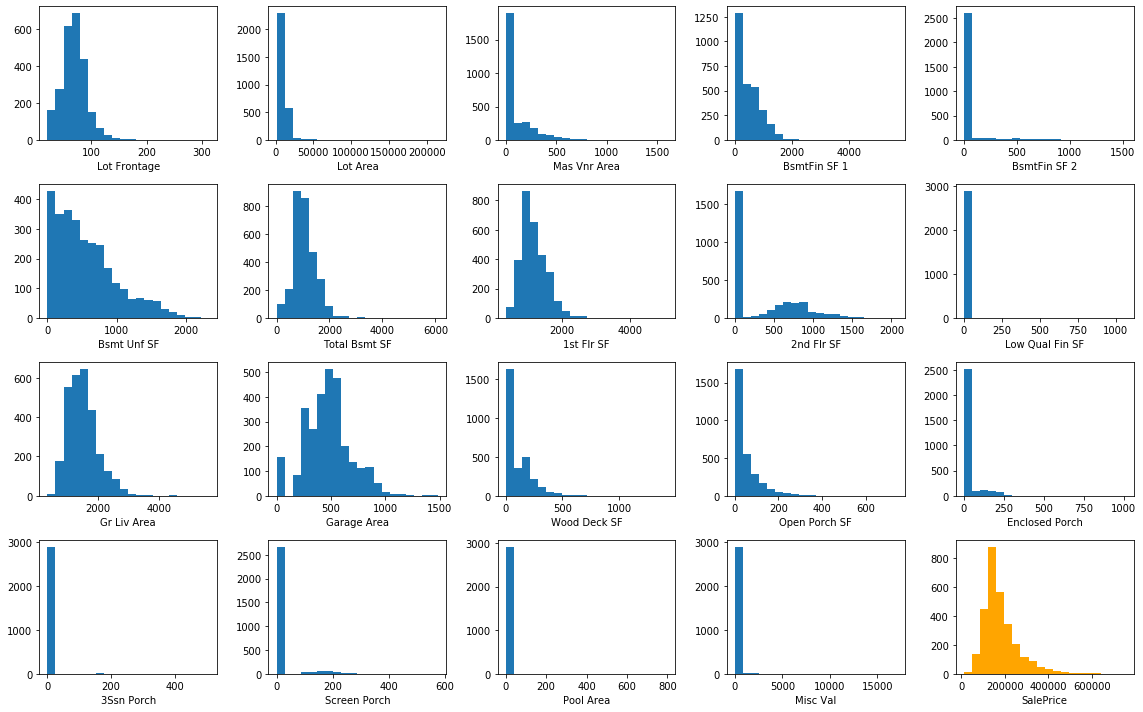

In [ ]:
fig,ax= plt.subplots(4,5,figsize=(16,10))
                 
hist_num=0
for row in range(0,3):
  for col in range(0,5):
    ax[row][col].hist(data[continuous_cols[hist_num]],bins=20)
    ax[row][col].set_xlabel(continuous_cols[hist_num])
    hist_num+=1

ax[3][0].hist(data['3Ssn Porch'],bins=20)
ax[3][0].set_xlabel(continuous_cols[hist_num])

ax[3][1].hist(data['Screen Porch'],bins=20)
ax[3][1].set_xlabel('Screen Porch')

ax[3][2].hist(data['Pool Area'],bins=20)
ax[3][2].set_xlabel('Pool Area')

ax[3][3].hist(data['Misc Val'],bins=20)
ax[3][3].set_xlabel('Misc Val')

ax[3][4].hist(data['SalePrice'],bins=20,color='orange')
ax[3][4].set_xlabel('SalePrice')

fig.tight_layout()

# Not all columns are uniformly distributed. Inorder to Normalize the data for having mean 0 and std 1 we need to apply StandardScaler on these continous variables.

Visualize the dependency of the target on each continuous feature 

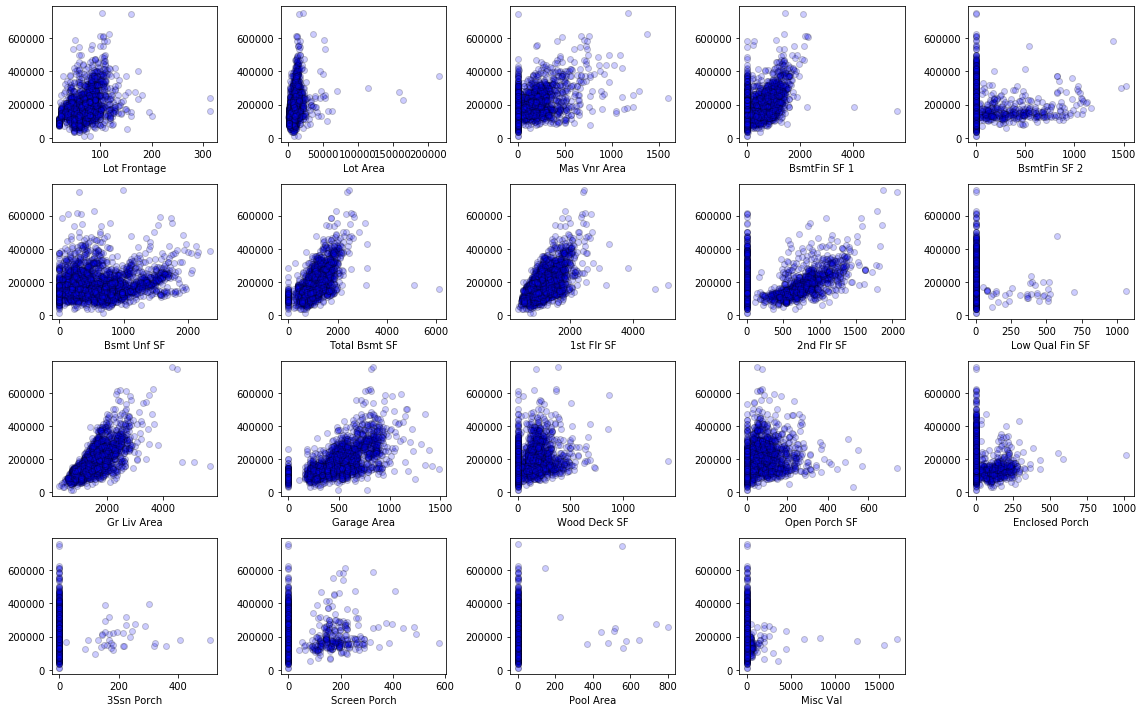

In [ ]:
fig,ax= plt.subplots(4,5,figsize=(16,10))

hist_num=0
for row in range(0,3):
  for col in range(0,5):
    ax[row][col].scatter(data[continuous_cols[hist_num]],data['SalePrice'],c='blue',alpha=0.2,edgecolors='black')
    ax[row][col].set_xlabel(continuous_cols[hist_num])
    hist_num+=1

ax[3][0].scatter(data['3Ssn Porch'],data['SalePrice'],c='blue',alpha=0.2,edgecolors='black')
ax[3][0].set_xlabel('3Ssn Porch')

ax[3][1].scatter(data['Screen Porch'],data['SalePrice'],c='blue',alpha=0.2,edgecolors='black')
ax[3][1].set_xlabel('Screen Porch')

ax[3][2].scatter(data['Pool Area'],data['SalePrice'],c='blue',alpha=0.2,edgecolors='black')
ax[3][2].set_xlabel('Pool Area')

ax[3][3].scatter(data['Misc Val'],data['SalePrice'],c='blue',alpha=0.2,edgecolors='black')
ax[3][3].set_xlabel('Misc Val')
fig.delaxes(ax[3][4])
fig.tight_layout()

#Garage Liv Area,1st Flr SF, Total Bsmt SF ,Garage Area seems to have linear relation to Sale Price

Train Test Split on data

In [ ]:
from sklearn.model_selection import train_test_split
X=data.drop(['SalePrice'], axis=1)
y=data['SalePrice']
X_train, X_test, y_train, y_test= train_test_split(X,y,random_state=0)
X_train.head()

,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition
896,50,RL,50.0,8405,Pave,4,Lvl,4,Inside,3,Edwards,Norm,Norm,1Fam,1.5Fin,2.1,1.2,1945,1950,Gable,CompShg,WdShing,Wd Shng,None,0.0,3,3,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,Wall,3,N,2.0,1088,441,0,1529,0.0,0.0,2,0,4,1,3,9,5,0,NaN,Detchd,1945.0,2,1.0,240.0,3.0,3.0,0,92,0,185,0,0,0,NaN,0,4,2009,WD,Normal
1901,20,RL,50.0,5000,Pave,4,Low,4,Inside,2,BrkSide,Norm,Norm,1Fam,1Story,1.1,1.2,1946,1950,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,2,Slab,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,GasA,2,N,2.0,334,0,0,334,0.0,0.0,1,0,1,1,2,2,8,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0,0,0,0,0,0,0,NaN,0,1,2007,WD,Normal
390,20,RL,78.0,10140,Pave,4,Lvl,4,Inside,3,NWAmes,Norm,Norm,1Fam,1Story,2.2,2.1,1974,1974,Hip,CompShg,HdBoard,HdBoard,BrkFace,174.0,3,3,CBlock,4.0,3.0,0.0,1.0,0.0,1.0,0.0,1064.0,1064.0,GasA,3,Y,0.0,1350,0,0,1350,0.0,0.0,2,0,3,1,3,7,8,1,3.0,Attchd,1974.0,1,2.0,478.0,3.0,3.0,2,0,0,0,0,0,0,1,0,8,2009,WD,Normal
1293,50,RM,63.0,7628,Pave,4,Lvl,4,Inside,3,OldTown,Norm,Norm,1Fam,1.5Fin,2.1,2.2,1940,1985,Gable,CompShg,MetalSd,MetalSd,None,0.0,3,4,BrkTil,3.0,3.0,0.0,1.0,0.0,1.0,0.0,801.0,801.0,GasA,4,Y,1.0,1095,561,0,1656,0.0,0.0,2,0,2,1,3,8,5,0,NaN,Detchd,1958.0,2,2.0,440.0,3.0,3.0,2,187,0,0,0,0,0,NaN,0,5,2008,WD,Normal
1767,60,RL,104.0,21535,Pave,3,Lvl,4,Corner,3,NoRidge,Norm,Norm,1Fam,2Story,3.3,2.2,1994,1995,Gable,WdShngl,HdBoard,HdBoard,BrkFace,1170.0,5,3,PConc,5.0,3.0,3.0,6.0,1455.0,1.0,0.0,989.0,2444.0,GasA,5,Y,0.0,2444,1872,0,4316,0.0,1.0,3,1,4,1,5,10,8,2,5.0,Attchd,1994.0,0,3.0,832.0,3.0,3.0,2,382,50,0,0,0,0,NaN,0,1,2007,WD,Normal


Visualize the relationship of the categorical variables that provide the best R^2 value with the target

In [ ]:
# Calculating r2 values

r2_cat_col_score=[]
pipe_categorical=Pipeline([('categorical_simpleimputer',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                           ('oneHotencoder',OneHotEncoder(handle_unknown='ignore'))])

model = Pipeline([('preprocessing',pipe_categorical),('Linear_regression',LinearRegression())])
# Iterating through single categorical column at a time
for col in cat_cols:
  score = cross_val_score(model,X_train[col].values.reshape(-1,1),y_train,cv=10,scoring='r2')
  r2_cat_col_score.append(np.mean(score))
# r2_cat_col_score

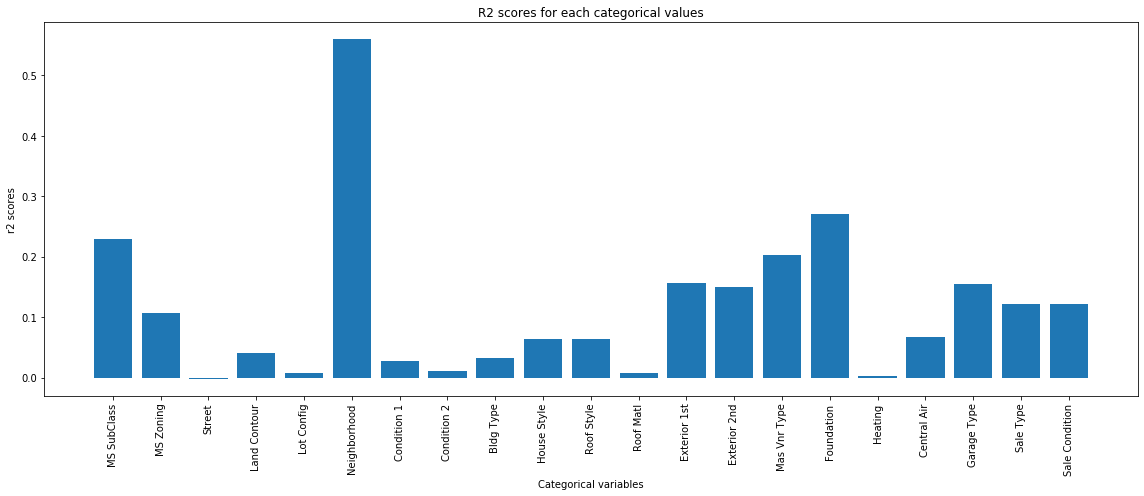

In [ ]:
# Graph of all categorical cols and their r2 scores
fig, ax1 = plt.subplots(figsize=(16, 7))
ax1.bar(cat_cols,r2_cat_col_score)
plt.xlabel('Categorical variables')
plt.ylabel('r2 scores')
plt.title('R2 scores for each categorical values')
plt.xticks(rotation=90)
fig.tight_layout()

# Neighborhood feature has most effect on the target

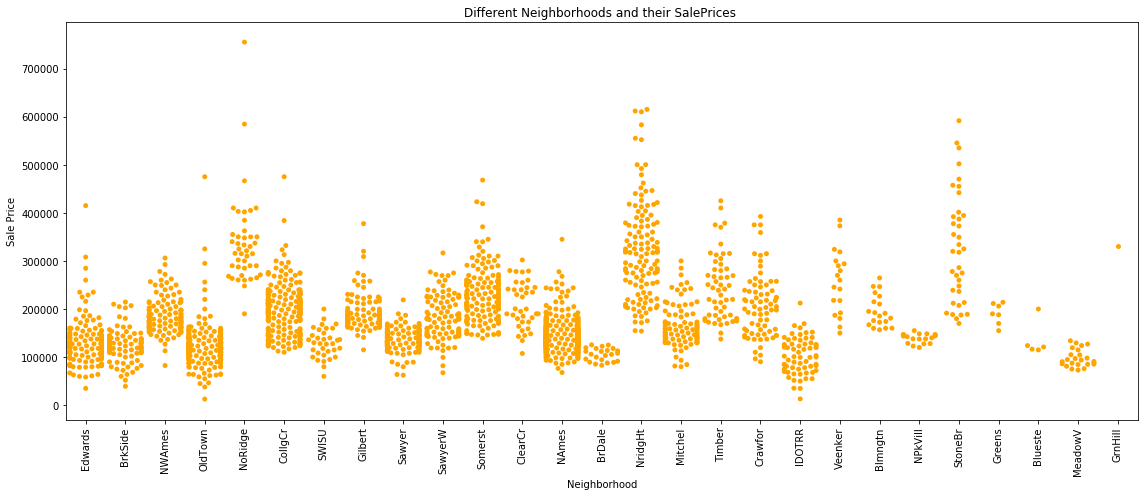

In [ ]:
fig, ax1 = plt.subplots(figsize=(16, 7))
ax1 = sns.swarmplot(x=X_train['Neighborhood'], y=y_train,color="orange")#.scatter(X_train['Neighborhood'],y_train)
plt.xlabel('Neighborhood')
plt.ylabel('Sale Price')
plt.title('Different Neighborhoods and their SalePrices ')
plt.xticks(rotation=90)
fig.tight_layout()

SimpleImputer "most_frequent" for Categorical and "mean" for numerical values
 and Evaluate Linear Regression (OLS),Ridge, Lasso and ElasticNet using cross-validation with the default parameters
(this cell takes 2 - 3 mins run time)

In [ ]:
# Create pipelines for each different types of attributes/Cols
pipe_continous_withStdScaler=Pipeline([('continuous_simpleimputer',SimpleImputer()),
                             ('standardscaler',StandardScaler())])
pipe_continous=Pipeline([('continuous_simpleimputer',SimpleImputer())])
pipe_categorical=Pipeline([('categorical_simpleimputer',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                           ('oneHotencoder',OneHotEncoder(handle_unknown='ignore'))])#OneHotEncoder(handle_unknown='ignore')
pipe_ordinal=Pipeline([('ordinalcols_simpleimputer',SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])
pipe_discrete=Pipeline([('discrete_simpleimputer',SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

# Column transformer for each column
transform= ColumnTransformer(
    [  ('continuous',pipe_continous,continuous_cols), 
     ('categorical', pipe_categorical,cat_cols),
     ('ordinal',pipe_ordinal,ordinal_cols),
     ('discrete',pipe_discrete,discrete_cols)
     ],  
    remainder='passthrough'  # Leave the rest of the columns untouched
  )

models=[Lasso(max_iter = 4000),Ridge(max_iter = 4000),ElasticNet(max_iter = 4000)]
cv_scores=[]
for model in models:
  sel_model = make_pipeline(
    transform,
    model)
  score= cross_val_score(sel_model,X_train,y_train,cv=10,scoring='r2')
  cv_scores.append(np.mean(score))


print("Cross validation score without Standard scaler for Lasso {:.2f}".format(cv_scores[0]))
print("Cross validation score without Standard scaler for Ridge {:.2f}".format(cv_scores[1]))
print("Cross validation score without Standard scaler for ElasticNet {:.2f}".format(cv_scores[2]))



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1004962304255.6582, tolerance: 1220505600.0285332
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1047473360007.8619, tolerance: 1258558128.0735834
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1060164519715.0619, tolerance: 1268974576.5142095
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 105953

Cross validation score without Standard scaler for Lasso 0.88
Cross validation score without Standard scaler for Ridge 0.87
Cross validation score without Standard scaler for ElasticNet 0.83


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1016740928207.777, tolerance: 1244382904.511223
  positive)


In [ ]:
# Cross validation for Linear Regression 

pipe_ordinal_lr=Pipeline([('ordinalcols_simpleimputer',SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                          ('onehot',OneHotEncoder(handle_unknown='ignore'))])
# Column transformer for each column
transform_lr= ColumnTransformer(
    [  ('continuous',pipe_continous,continuous_cols), 
     ('categorical', pipe_categorical,cat_cols),
     ('ordinal',pipe_ordinal_lr,ordinal_cols),
     ('discrete',pipe_discrete,discrete_cols)
     ],  
    remainder='passthrough'  # Leave the rest of the columns untouched
  )

sel_model = make_pipeline(
    transform_lr,
    LinearRegression())
score_lr= cross_val_score(sel_model,X_train,y_train,cv=10,scoring='r2')

print("Cross validation score without Standard scaler for Linear Regression {:.2f}".format(np.mean(score_lr)))

#With Standard Scaler
# Column transformer for each column
transform_lr_stdscaler= ColumnTransformer(
    [  ('continuous',pipe_continous_withStdScaler,continuous_cols), 
     ('categorical', pipe_categorical,cat_cols),
     ('ordinal',pipe_ordinal_lr,ordinal_cols),
     ('discrete',pipe_discrete,discrete_cols)
     ],  
    remainder='passthrough'  # Leave the rest of the columns untouched
  )
sel_model = make_pipeline(
    transform_lr_stdscaler,
    LinearRegression())
score_lr= cross_val_score(sel_model,X_train,y_train,cv=10,scoring='r2')

print("Cross validation score with Standard scaler for Linear Regression {:.2f}".format(np.mean(score_lr)))
# There is no change observed with or without standard scaler because Linear equations do not need scaling

Cross validation score without Standard scaler for Linear Regression 0.88
Cross validation score with Standard scaler for Linear Regression 0.88


With Standard Scaler with default parameters

In [ ]:
# Column transformer for each column
transform= ColumnTransformer(
    [  ('continuous',pipe_continous_withStdScaler,continuous_cols), 
     ('categorical', pipe_categorical,cat_cols),
    ('ordinal',pipe_ordinal,ordinal_cols),
     ('discrete',pipe_discrete,discrete_cols)
     ],  
    remainder='passthrough'  # Leave the rest of the columns untouched
  )

models=[Lasso(max_iter = 4000),Ridge(max_iter = 4000),ElasticNet(max_iter = 4000)]
cv_scores=[]
for model in models:
  sel_model = make_pipeline(
    transform,
    model)
  score= cross_val_score(sel_model,X_train,y_train,cv=10)
  cv_scores.append(np.mean(score))
print("Cross validation score with Standard scaler for Lasso {:.2f}".format(cv_scores[0]))
print("Cross validation score with Standard scaler for Ridge {:.2f}".format(cv_scores[1]))
print("Cross validation score with Standard scaler for ElasticNet {:.2f}".format(cv_scores[2]))


# With standard scaler Lasso,Elastic scores not changed but Ridge has noticable improvement in score. Because regularization algorithms performance improves by scaling


Cross validation score with Standard scaler for Lasso 0.88
Cross validation score with Standard scaler for Ridge 0.87
Cross validation score with Standard scaler for ElasticNet 0.83


Function for creating Graph between Test score and Train Score after GridSearchCV

In [ ]:
def param_to_score_plot(grid,model_name):
  train_scores_mean = grid.cv_results_["mean_train_score"]
  train_scores_std = grid.cv_results_["std_train_score"]
  test_scores_mean = grid.cv_results_["mean_test_score"]
  test_scores_std = grid.cv_results_["std_test_score"]

  plt.figure()
  plt.title(model_name)
  plt.xlabel('$\\alpha$ (alpha)')
  plt.ylabel('Score')
# plot train scores
  plt.semilogx(alphas, train_scores_mean, label='Mean Train score',
             color='navy')
# create a shaded area between [mean - std, mean + std]
  plt.gca().fill_between(alphas,
                       train_scores_mean - train_scores_std,
                       train_scores_mean + train_scores_std,
                       alpha=0.2,
                       color='navy')
  plt.semilogx(alphas, test_scores_mean,
             label='Mean Test score', color='darkorange')

# create a shaded area between [mean - std, mean + std]
  plt.gca().fill_between(alphas,
                       test_scores_mean - test_scores_std,
                       test_scores_mean + test_scores_std,
                       alpha=0.2,
                       color='darkorange')

  plt.legend(loc='best')
  plt.show()

In [ ]:
# Function for mapping coefficients with attributes
def get_avg_coef_scores(col_names, best_model_features, best_model_coef):
    scores = {}
    start_pos = 0
    for col in col_names:
      if col in cat_cols:
        num_vect_feats = len([i for i in best_model_features if i.split('_')[0] == col])
        end_pos = start_pos + num_vect_feats
        # print(col , start_pos,end_pos,best_model_coef[start_pos:end_pos])
        scores[col ] = np.mean(best_model_coef[start_pos:end_pos])
        start_pos = end_pos
      # elif col in ordinal_cols:
      #   num_vect_feats = len([i for i in best_model_features1 if i.split('_')[0] == col])
      #   end_pos = start_pos + num_vect_feats
      #   print(col , start_pos,end_pos,best_model_coef[start_pos:end_pos])
      #   scores[col + '_avg_coef_score'] = np.mean(best_model_coef[start_pos:end_pos])
      #   start_pos = end_pos
      else:
        end_pos=end_pos+1
        # print(col , start_pos,end_pos,best_model_coef[start_pos:end_pos])
        scores[col] = best_model_coef[start_pos:end_pos]
        start_pos = end_pos
    return scores

In [ ]:
# Function for Grapgh between coefficients and attributes
def coefficients_graph(model_name,best_model):
  best_model_coef= best_model.named_steps[model_name].coef_
  best_model_features= best_model.named_steps['data_preprocessing'].transformers_[1][1]\
   .named_steps['oneHotencoder'].get_feature_names(cat_cols)
  col_names = list(X_train.columns)
  scores = get_avg_coef_scores(col_names,best_model_features,best_model_coef)
  fig, ax1 = plt.subplots(figsize=(20, 7))
  ax1.plot(X_train.columns,[v for k,v in scores.items()])
  plt.xlabel('Attributes')
  plt.ylabel('coefficients')
  plt.title('coefficients for attributes')
  plt.xticks(rotation=90)
  fig.tight_layout()

Lasso GridSearchCV and Coefficients plot (Runtime: 1min)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   13.6s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:   34.3s finished


{'Lasso__alpha': 10.0}
0.9256390358826105


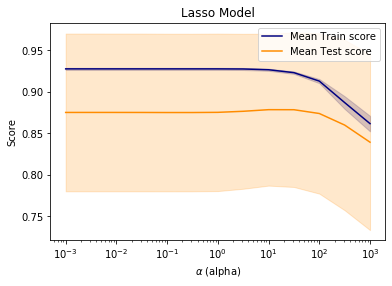

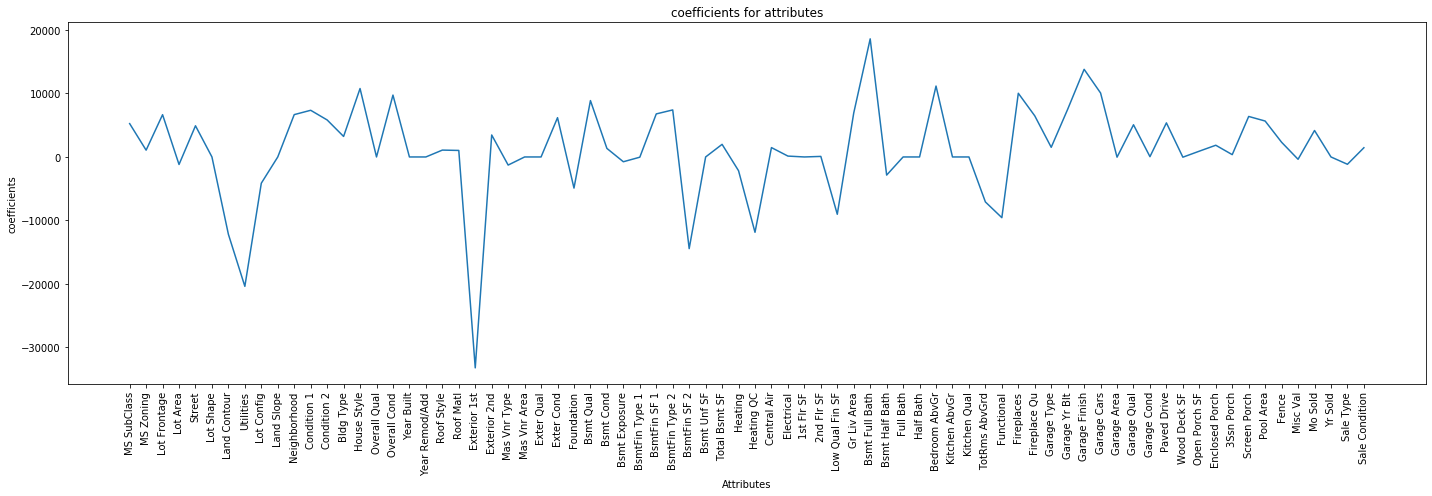

In [ ]:
# Lasso GridSearchCV
alphas = np.logspace(-3, 3, 13)

param_grid = {'Lasso__alpha': alphas}#,"data_preprocessing__continuous__continuous_simpleimputer__strategy": ["mean", "median"]}


full_pipeline_with_predictor = Pipeline(
    [("data_preprocessing", transform), ("Lasso", Lasso())])

grid = GridSearchCV(full_pipeline_with_predictor, param_grid, cv=10,verbose=2, n_jobs=8,return_train_score=True, scoring='r2')
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.score(X_train,y_train))
param_to_score_plot(grid,'Lasso Model')
coefficients_graph('Lasso',grid.best_estimator_)


Ridge GridSearchCV(Runitime : less than a minute)

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:   11.0s finished


{'Ridge__alpha': 0.31622776601683794}
0.924685507612246


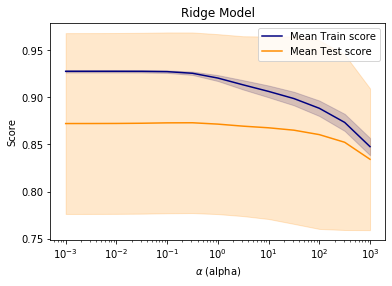

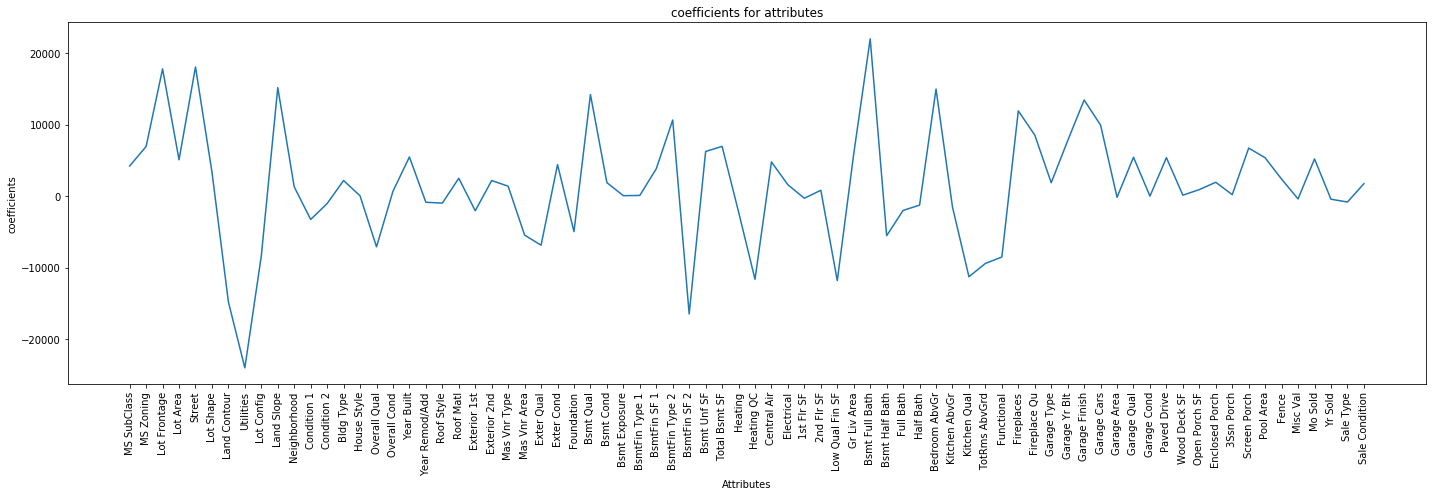

In [ ]:
from sklearn.pipeline import Pipeline

alphas = np.logspace(-3, 3, 13)



param_grid = {'Ridge__alpha': alphas}#,"data_preprocessing__continuous__continuous_simpleimputer__strategy": ["mean", "median"]}

full_pipeline_with_predictor = Pipeline(
    [("data_preprocessing", transform), ("Ridge", Ridge())])

grid = GridSearchCV(full_pipeline_with_predictor, param_grid, cv=10,verbose=2, n_jobs=8,return_train_score=True, scoring='r2')
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.score(X_train,y_train))
param_to_score_plot(grid,'Ridge Model')
coefficients_graph('Ridge',grid.best_estimator_)


ElasticNet GridSearchCV

Fitting 10 folds for each of 13 candidates, totalling 130 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    9.3s
[Parallel(n_jobs=8)]: Done 130 out of 130 | elapsed:   20.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 609159831737.2206, tolerance: 1391468446.6790373
  positive)


{'ElasticNet__alpha': 0.001}
0.9189667153742707


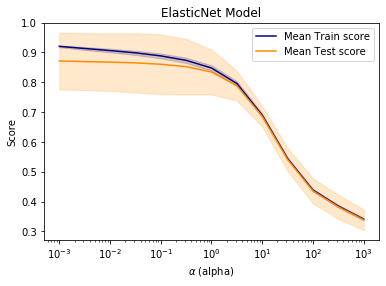

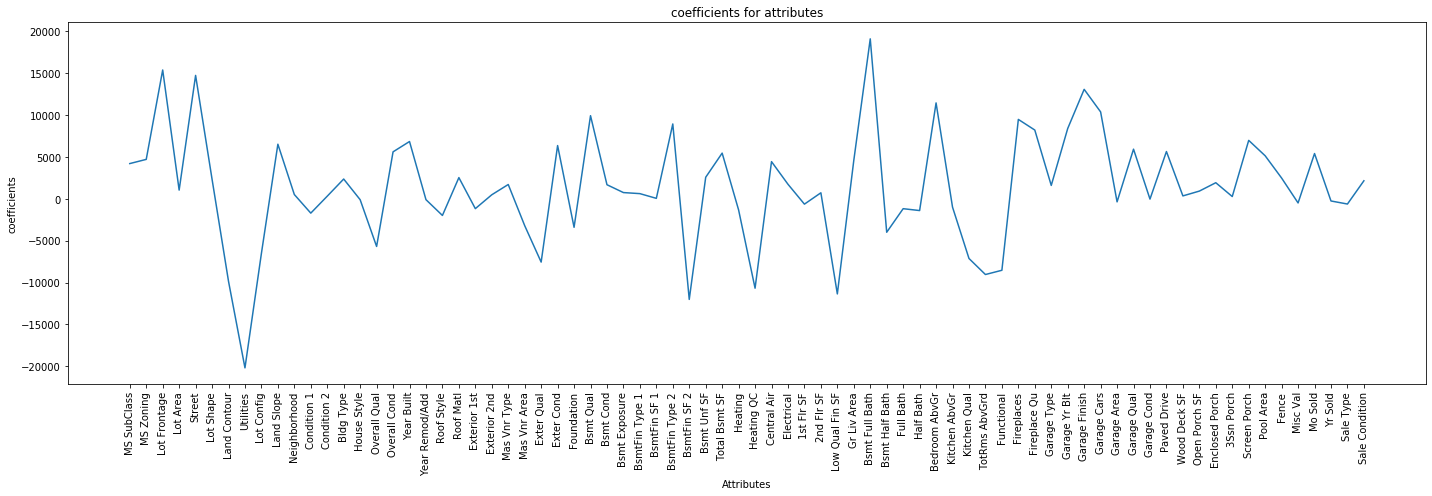

In [ ]:
from sklearn.pipeline import Pipeline

alphas = np.logspace(-3, 3, 13)
param_grid = {'ElasticNet__alpha': alphas}#,"data_preprocessing__continuous__continuous_simpleimputer__strategy": ["mean", "median"]}

full_pipeline_with_predictor = Pipeline(
    [("data_preprocessing", transform), ("ElasticNet", ElasticNet())])

grid = GridSearchCV(full_pipeline_with_predictor, param_grid, cv=10,verbose=2, n_jobs=8,return_train_score=True, scoring='r2')
grid.fit(X_train,y_train)
print(grid.best_params_)
print(grid.score(X_train,y_train))
param_to_score_plot(grid,'ElasticNet Model')
coefficients_graph('ElasticNet',grid.best_estimator_)
# The coefficients agree on which features are important for Example GR Liv Area has large weight